# Download Data

In [ ]:
# downloading DataSet
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz

--2021-05-20 12:25:35--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9517526 (9.1M) [application/x-gzip]
Saving to: ‘reviews_Amazon_Instant_Video_5.json.gz’

reviews_Amazon_Inst 100%[===================>]   9.08M  3.70MB/s    in 2.5s    

2021-05-20 12:25:38 (3.70 MB/s) - ‘reviews_Amazon_Instant_Video_5.json.gz’ saved [9517526/9517526]



In [ ]:
#Download Data For Glove Embedding
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-05-20 12:25:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-20 12:25:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-20 12:25:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#installing libraries
!pip install transformers
!pip install -U mittens
!pip install --upgrade keras

     |████████████████████████████████| 2.3MB 9.6MB/s 
     |████████████████████████████████| 901kB 38.7MB/s 
     |████████████████████████████████| 3.3MB 37.3MB/s 
Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)


# Importing required libraries

In [ ]:
import re
import os
import json
import gzip
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from mittens import GloVe, Mittens

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve,plot_confusion_matrix,confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB , BernoulliNB
from sklearn.tree import DecisionTreeClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding

from collections import Counter
from mittens import GloVe, Mittens
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

import torch

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Data Pre-Processing

## Loading Data

In [ ]:
# load data
data = []
with gzip.open('reviews_Amazon_Instant_Video_5.json.gz') as file:
    for line in file:
        data.append(json.loads(line.strip()))

# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

print('Total number of reviews are: ',len(data))

# Viewing first 5 reviews
df.head(5)

Total number of reviews are:  37126


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2.0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5.0,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1.0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4.0,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5.0,Robson green and great writing,1234310400,"02 11, 2009"


**Attribute Information:**

1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

2. asin - ID of the product, e.g. 0000013714

3. reviewerName - name of the reviewer

4. helpful - helpful votes of the review

5. reviewText - text of the review

6. overall - rating of the product

7. summary - summary of the review

8. unixReviewTime - time of the review (unix time)

9. reviewTime - time of the review (raw)


In [ ]:
df.columns #verifying for columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

## Modifying the overall to our requirements

In [ ]:
def modify_overall(overall):
  ''' 
  Function to modify overall:
    overall greater than 3 is changed to 1(positive sentiment) 
    overall less than or equal to 3 is changed to 0(negative sentiment)
  Input: overall
  Output: Modified overall
  '''
  if overall <= 3:
      return 0
  return 1

In [ ]:
actualScore = df['overall']
new_score = actualScore.map(modify_overall) 
df['overall'] = new_score
print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (37126, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,1,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,1,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",1,Robson green and great writing,1234310400,"02 11, 2009"


## Cleaning Data

In [ ]:
''' Remove the duplicates which have same reviewerID, asin, unixReviewTime, and reviewText '''
new = df.drop_duplicates(subset={"reviewerID","asin","unixReviewTime","reviewText"}, keep='first', inplace=False)
new.shape

(37126, 9)

In [ ]:

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ma'])

## Required functions

In [ ]:
def decontracted(phrase):
    ''' 
      Function used to decontact the words in the phrase
      Input: phrase
      Output: decontracted phrase
    '''
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
def pipeline(review): 
  '''
     Input: list of review
     Output: processed reviews 
  '''
  processed_reviews = []
  for sentence in tqdm(review):
    sentence = sentence.lower() #converting all letters in the sentence to lowercase
    sentence = decontracted(sentence) #decontact the sentence in the review
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) #retaining only alphabets in the sentence 

    #Word tokenization
    word_tokens = word_tokenize(sentence) 

    #Stop word removal
    filtered_sentence = [w for w in word_tokens if  w not in stopwords]
    
    #Lemmatization
    wnl = WordNetLemmatizer()
    filtered_sentence = [wnl.lemmatize(w) for w in filtered_sentence ]

    final = ' '.join(filtered_sentence)
    processed_reviews.append(final)
  return processed_reviews


## Creating required variables

In [ ]:
reviews = df['reviewText'].values
score = df['overall'].values

In [ ]:
#filtering review
reviews = pipeline(reviews)

100%|██████████| 37126/37126 [00:26<00:00, 1418.24it/s]


# Using the same data as your Assignment 1, Develop an 
- Bi-LSTM based sentiment analysis model using (a) TF-IDF embeddings, (b) word2vec embeddings (c) glove embeddings. 

- BERT based sentiment analysis model. 

- Compare the performance on the test set among these models. (Bi-LSTM (with tf-idf, word2vec, glove), BERT) 

- Traditional ML Models developed in assignment 1.



We have completed TF-IDF before it is scraped. In particular instead of word embedding TF-IDF produced document embedding. So, we fed document embedding to LSTM Model. Since, TF-IDF follows BoW model it does not make any sence to fed it to LSTM since sequence information is lost. Here LSTM simply perform classification with no relevent sequence information. 

# Bi- LSTM using TF-IDF embeddings

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(max_features=500)

#transformed train reviews
tf_idf_vect = tf_idf_vect.fit_transform(reviews).toarray()

print('tf_idf_vect size : ',tf_idf_vect.shape)



tf_idf_vect size :  (37126, 500)


In [ ]:
X = tf_idf_vect.reshape(tf_idf_vect.shape[0],1,tf_idf_vect.shape[-1])

In [ ]:
# Train and test split in 8:2 ratio
x_train, x_test, y_train, y_test = train_test_split(X, score, test_size=0.2)

In [ ]:
model=Sequential()
model.add(Bidirectional(LSTM(20, return_sequences=False), input_shape=(1, 500)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_18 (Bidirectio (None, 40)                83360     
_________________________________________________________________
dropout_15 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                2624      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 90,209
Trainable params: 90,209
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Fit train data
history = model.fit(x_train, y_train,validation_split=0.2,batch_size=32, epochs =20)

Epoch 1/20
743/743 [==============================] - 7s 6ms/step - loss: 0.6056 - accuracy: 0.7741 - val_loss: 0.4672 - val_accuracy: 0.7911
Epoch 2/20
743/743 [==============================] - 3s 5ms/step - loss: 0.4409 - accuracy: 0.7933 - val_loss: 0.3760 - val_accuracy: 0.8310
Epoch 3/20
743/743 [==============================] - 3s 5ms/step - loss: 0.3656 - accuracy: 0.8381 - val_loss: 0.3615 - val_accuracy: 0.8332
Epoch 4/20
743/743 [==============================] - 3s 5ms/step - loss: 0.3550 - accuracy: 0.8399 - val_loss: 0.3586 - val_accuracy: 0.8365
Epoch 5/20
743/743 [==============================] - 3s 5ms/step - loss: 0.3432 - accuracy: 0.8478 - val_loss: 0.3564 - val_accuracy: 0.8369
Epoch 6/20
743/743 [==============================] - 3s 5ms/step - loss: 0.3460 - accuracy: 0.8470 - val_loss: 0.3564 - val_accuracy: 0.8391
Epoch 7/20
743/743 [==============================] - 3s 5ms/step - loss: 0.3376 - accuracy: 0.8524 - val_loss: 0.3566 - val_accuracy: 0.8404
Epoch 

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

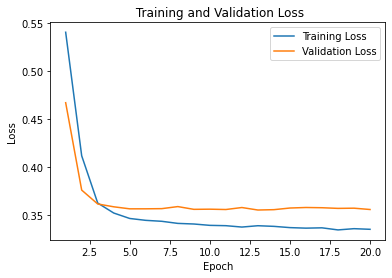

In [ ]:

x = [i for i in range(1,21)]

plt.title(" Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x,t_loss,label='Training Loss')
plt.plot(x,v_loss,label='Validation Loss')

plt.legend()
plt.show()

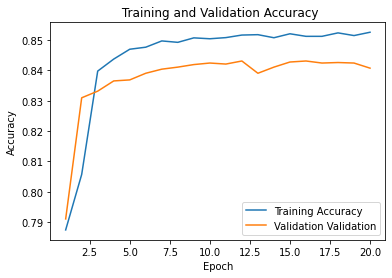

In [ ]:
x = [i for i in range(1,21)]

plt.title(" Training and Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(x,accuracy,label='Training Accuracy')
plt.plot(x,val_accuracy,label='Validation Validation')

plt.legend()
plt.show()

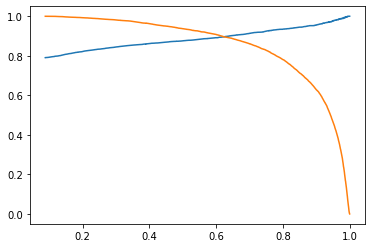

Crossover at 0.62 with recall 0.90


In [ ]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr == rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]
print("Crossover at {0:.2f} with recall {1:.2f}".format(crossover_cutoff, crossover_recall))


In [ ]:
print(classification_report(y_test, y_pred > crossover_cutoff))



              precision    recall  f1-score   support

           0       0.61      0.61      0.61      1565
           1       0.90      0.90      0.90      5861

    accuracy                           0.84      7426
   macro avg       0.75      0.75      0.75      7426
weighted avg       0.84      0.84      0.84      7426



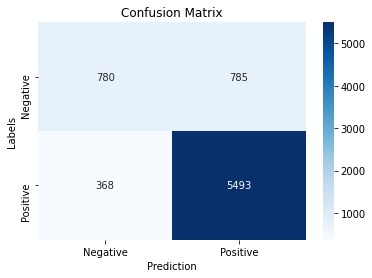

In [ ]:
y = np.round(np.clip(y_pred, 0, 1))
cf = confusion_matrix(y_test,y)


x_axis_labels= ['Negative', 'Positive']
y_axis_labels= ['Negative', 'Positive']


sn.heatmap(cf, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cmap='Blues', fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Labels")
plt.title('Confusion Matrix')
plt.show()

# Bi- LSTM using  Word2Vec embeddings

In [ ]:
data = []
for i in tqdm(reviews):
  data.append(i.split(' '))
  

100%|██████████| 37126/37126 [00:00<00:00, 196654.51it/s]


In [ ]:
#trains w2v model on data set
w2v_model=Word2Vec(data,min_count=1,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 1 times ",len(w2v_words))
print("sample words ", w2v_words[0:20])

number of words that occured minimum 1 times  47561
sample words  ['big', 'expectation', 'love', 'english', 'tv', 'particular', 'investigative', 'detective', 'stuff', 'guy', 'really', 'boring', 'not', 'appeal', 'highly', 'recommend', 'series', 'must', 'anyone', 'yearning']


In [ ]:
# Finding length of longest review
max_length = 0
for i in reviews:
  len_ = len(i.split(' '))
  if(len_ > max_length):
    max_length = len_


In [ ]:
# Tokenizing Data
token = Tokenizer()
token.fit_on_texts(reviews)
vocab_size = len(token.word_index) + 1
encoded = token.texts_to_sequences(reviews)
padded_data = pad_sequences(encoded, maxlen=max_length, padding='post')

vocab_size = len(token.word_index) + 1

In [ ]:
#Creating Embedding matrix using trained word to vec model
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in token.word_index.items():
    embedding_vector = w2v_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Train and test split in 8:2 ratio
x_train, x_test, y_train, y_test = train_test_split(padded_data, score, test_size=0.2)

In [ ]:
# Designing Bidirectional LSTM network
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=True))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(20)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(lr=0.0005)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1641, 50)          2378050   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 1641, 40)          11360     
_________________________________________________________________
dropout_22 (Dropout)         (None, 1641, 40)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 1641, 40)          160       
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 1641, 40)          9760      
_________________________________________________________________
dropout_23 (Dropout)         (None, 1641, 40)          0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1641, 40)        

In [ ]:
## Fit train data
history = model.fit(x_train, y_train,validation_split=0.2,batch_size=32, epochs =10)

Epoch 1/10
743/743 [==============================] - 270s 353ms/step - loss: 0.5105 - accuracy: 0.7563 - val_loss: 0.4241 - val_accuracy: 0.8158
Epoch 2/10
743/743 [==============================] - 262s 352ms/step - loss: 0.4053 - accuracy: 0.8129 - val_loss: 0.3961 - val_accuracy: 0.8025
Epoch 3/10
743/743 [==============================] - 263s 354ms/step - loss: 0.3796 - accuracy: 0.8273 - val_loss: 0.3689 - val_accuracy: 0.8279
Epoch 4/10
743/743 [==============================] - 264s 355ms/step - loss: 0.3602 - accuracy: 0.8368 - val_loss: 0.3575 - val_accuracy: 0.8261
Epoch 5/10
743/743 [==============================] - 265s 356ms/step - loss: 0.3299 - accuracy: 0.8566 - val_loss: 0.3739 - val_accuracy: 0.8293
Epoch 6/10
743/743 [==============================] - 264s 356ms/step - loss: 0.2970 - accuracy: 0.8733 - val_loss: 0.3439 - val_accuracy: 0.8544
Epoch 7/10
743/743 [==============================] - 265s 356ms/step - loss: 0.2506 - accuracy: 0.9007 - val_loss: 0.4235 -

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

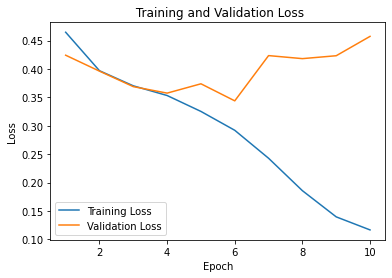

In [ ]:

x = [i for i in range(1,11)]

plt.title(" Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x,t_loss,label='Training Loss')
plt.plot(x,v_loss,label='Validation Loss')

plt.legend()
plt.show()

After 6 epochs data is overfitting

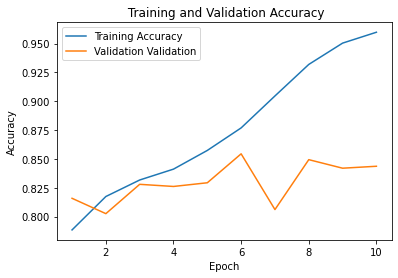

In [ ]:
x = [i for i in range(1,11)]

plt.title(" Training and Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(x,accuracy,label='Training Accuracy')
plt.plot(x,val_accuracy,label='Validation Validation')

plt.legend()
plt.show()

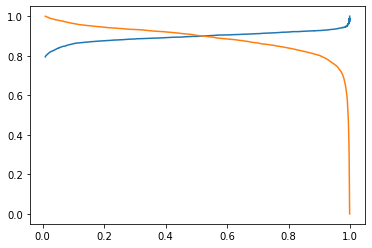

Crossover at 0.52 with recall 0.90


In [ ]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr == rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]
print("Crossover at {0:.2f} with recall {1:.2f}".format(crossover_cutoff, crossover_recall))


In [ ]:
print(classification_report(y_test, y_pred > crossover_cutoff))



              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1542
           1       0.90      0.90      0.90      5884

    accuracy                           0.84      7426
   macro avg       0.76      0.76      0.76      7426
weighted avg       0.84      0.84      0.84      7426



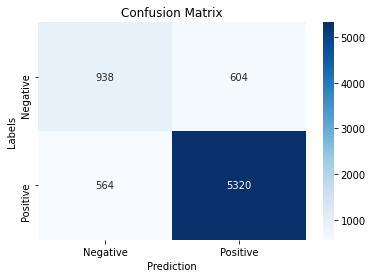

In [ ]:
y = np.round(np.clip(y_pred, 0, 1))
cf = confusion_matrix(y_test,y)


x_axis_labels= ['Negative', 'Positive']
y_axis_labels= ['Negative', 'Positive']


sn.heatmap(cf, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cmap='Blues', fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Labels")
plt.title('Confusion Matrix')
plt.show()

# Bi- LSTM using glove embeddings

In [ ]:
# Finding length of longest review
max_length = 0
for i in reviews:
  len_ = len(i.split(' '))
  if(len_ > max_length):
    max_length = len_


In [ ]:
data = []
for i in tqdm(reviews):
  data.append(i.split(' '))

100%|██████████| 37126/37126 [00:00<00:00, 69929.24it/s]


In [ ]:
# Reading glove embedding file and creating embedding dictionary
# Using 50 dimension embedding vector
initial_embeddings = dict()
f = open('./glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    initial_embeddings[word] = coefs
f.close()

In [ ]:
#Finding words not in vocabolary
oov = []
for i in data:
  for j in i :
    if ((j not in initial_embeddings.keys()) and (j not in oov)):
      oov.append(j)
corp_vocab = list(set(oov))

cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
X = cv.fit_transform(reviews)
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

In [ ]:
mittens_model = Mittens(n=50, max_iter=500)
new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=corp_vocab,
    initial_embedding_dict= initial_embeddings)

Iteration 500: loss: 3.224574565887451

In [ ]:
embeddings_index = initial_embeddings
for i in tqdm(range(len(oov))):
  embeddings_index[oov[i]] = new_embeddings[i]

100%|██████████| 9942/9942 [00:00<00:00, 734577.67it/s]


In [ ]:
# Tokenizing Data
token = Tokenizer()
token.fit_on_texts(reviews)
vocab_size = len(token.word_index) + 1
encoded = token.texts_to_sequences(reviews)
padded_data = pad_sequences(encoded, maxlen=max_length, padding='post')

vocab_size = len(token.word_index) + 1


In [ ]:
#Creating Embedding matrix using Glove Vector
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Train and test split in 8:2 ratio
x_train, x_test, y_train, y_test = train_test_split(padded_data, score, test_size=0.2)


In [ ]:
# Designing Bidirectional LSTM network
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_length, weights=[embedding_matrix], trainable=True))
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(20, return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(20)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
optimizer = keras.optimizers.Adam(lr=0.0005)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1641, 50)          2378050   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 1641, 40)          11360     
_________________________________________________________________
dropout_25 (Dropout)         (None, 1641, 40)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1641, 40)          160       
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 1641, 40)          9760      
_________________________________________________________________
dropout_26 (Dropout)         (None, 1641, 40)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1641, 40)        

In [ ]:
## Fit train data
history = model.fit(x_train, y_train,validation_split=0.2,batch_size=32, epochs =10)

Epoch 1/10
743/743 [==============================] - 271s 354ms/step - loss: 0.5311 - accuracy: 0.7720 - val_loss: 0.4730 - val_accuracy: 0.7887
Epoch 2/10
743/743 [==============================] - 262s 353ms/step - loss: 0.4532 - accuracy: 0.7902 - val_loss: 0.4043 - val_accuracy: 0.8185
Epoch 3/10
743/743 [==============================] - 264s 355ms/step - loss: 0.3926 - accuracy: 0.8203 - val_loss: 0.3695 - val_accuracy: 0.8372
Epoch 4/10
743/743 [==============================] - 264s 356ms/step - loss: 0.3453 - accuracy: 0.8518 - val_loss: 0.3513 - val_accuracy: 0.8476
Epoch 5/10
743/743 [==============================] - 265s 357ms/step - loss: 0.2983 - accuracy: 0.8747 - val_loss: 0.3386 - val_accuracy: 0.8544
Epoch 6/10
743/743 [==============================] - 266s 357ms/step - loss: 0.2593 - accuracy: 0.8965 - val_loss: 0.3597 - val_accuracy: 0.8537
Epoch 7/10
743/743 [==============================] - 266s 357ms/step - loss: 0.2256 - accuracy: 0.9136 - val_loss: 0.3845 -

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
t_loss = history.history['loss']
v_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

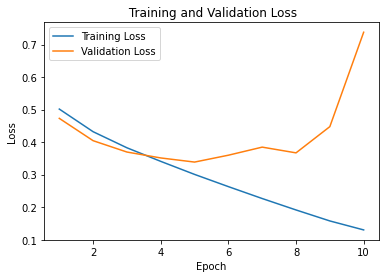

In [ ]:

x = [i for i in range(1,11)]

plt.title(" Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(x,t_loss,label='Training Loss')
plt.plot(x,v_loss,label='Validation Loss')

plt.legend()
plt.show()

Model Over fit after 5 epochs

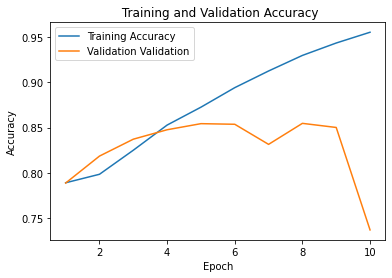

In [ ]:
x = [i for i in range(1,11)]

plt.title(" Training and Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(x,accuracy,label='Training Accuracy')
plt.plot(x,val_accuracy,label='Validation Validation')

plt.legend()
plt.show()

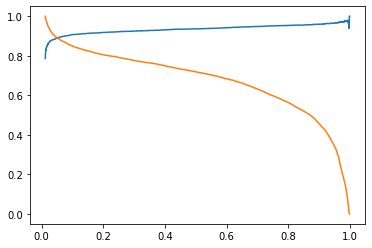

Crossover at 0.05 with recall 0.89


In [ ]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr == rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]
print("Crossover at {0:.2f} with recall {1:.2f}".format(crossover_cutoff, crossover_recall))


In [ ]:
print(classification_report(y_test, y_pred > crossover_cutoff))



              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1611
           1       0.89      0.89      0.89      5815

    accuracy                           0.83      7426
   macro avg       0.75      0.75      0.75      7426
weighted avg       0.83      0.83      0.83      7426



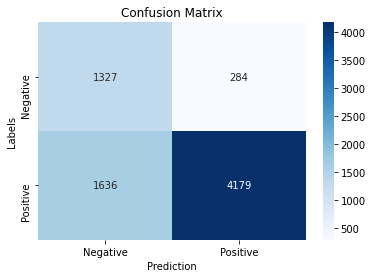

In [ ]:
y = np.round(np.clip(y_pred, 0, 1))
cf = confusion_matrix(y_test,y)


x_axis_labels= ['Negative', 'Positive']
y_axis_labels= ['Negative', 'Positive']


sn.heatmap(cf, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels,cmap='Blues', fmt='g')
plt.xlabel("Prediction")
plt.ylabel("Labels")
plt.title('Confusion Matrix')
plt.show()

# BERT based sentiment analysis model. 

Setting up GPU

In [ ]:
import torch

if torch.cuda.is_available():        
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


## Tokenization and Input Fromatting

In [ ]:
reviews = reviews[:1000]
score = score[:1000]

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Apply the tokenizer to one sentence just to see the output.

In [ ]:
# Print the original sentence.
print(' Original: ', reviews[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(reviews[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[0])))

 Original:  big expectation love english tv particular investigative detective stuff guy really boring not appeal
Tokenized:  ['big', 'expectation', 'love', 'english', 'tv', 'particular', 'investigative', 'detective', 'stuff', 'guy', 'really', 'boring', 'not', 'appeal']
Token IDs:  [2502, 17626, 2293, 2394, 2694, 3327, 15025, 6317, 4933, 3124, 2428, 11771, 2025, 5574]


In [ ]:
max_len = 0

# For every sentence...
for sent in tqdm(reviews):
    if len(sent)>512:
      sent = sent[:512]

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print()
print('Max sentence length: ', max_len)

100%|██████████| 1000/1000 [00:00<00:00, 1029.27it/s]


Max sentence length:  108


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in tqdm(reviews):

    encoded_dict = tokenizer.encode_plus(
                        sent,                     
                        add_special_tokens = True, 
                        max_length = 256,           
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',    
                   )
    
   
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(score)

# Print sentence 0, now as a list of IDs.
print('Original: ', reviews[0])
print('Token IDs:', input_ids[0])

100%|██████████| 1000/1000 [00:01<00:00, 567.65it/s]

Original:  big expectation love english tv particular investigative detective stuff guy really boring not appeal
Token IDs: tensor([  101,  2502, 17626,  2293,  2394,  2694,  3327, 15025,  6317,  4933,
         3124,  2428, 11771,  2025,  5574,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    

## Training and Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  900 training samples
  100 validation samples


create an iterator for our dataset using the torch DataLoader class

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16
 
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size 
        )


## BertForSequenceClassification

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,  
    output_attentions = False, 
    output_hidden_states = False,
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

Optimizer & Learning Rate Scheduler

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 16 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)   


In [ ]:
from transformers import get_linear_schedule_with_warmup


epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

Training Loop

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np
.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()


    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0).
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     57.    Elapsed: 0:00:16.

  Average training loss: 0.43
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.39
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     57.    Elapsed: 0:00:16.

  Average training loss: 0.36
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.42
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     57.    Elapsed: 0:00:16.

  Average training loss: 0.29
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.35
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     57.    Elapsed: 0:00:16.

  Average training loss: 0.23
  Training epcoh took: 0:00:23

Running Validation...
  Accuracy: 0.85
  Validation Loss: 0.35
  Validation took: 0:00:01

Training complete!
Total tr

Summary of Training 

In [ ]:
import pandas as pd

pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)


df_stats = df_stats.set_index('epoch')

df_stats


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.43,0.39,0.87,0:00:23,0:00:01
2,0.36,0.42,0.87,0:00:23,0:00:01
3,0.29,0.35,0.85,0:00:23,0:00:01
4,0.23,0.35,0.85,0:00:23,0:00:01


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data.

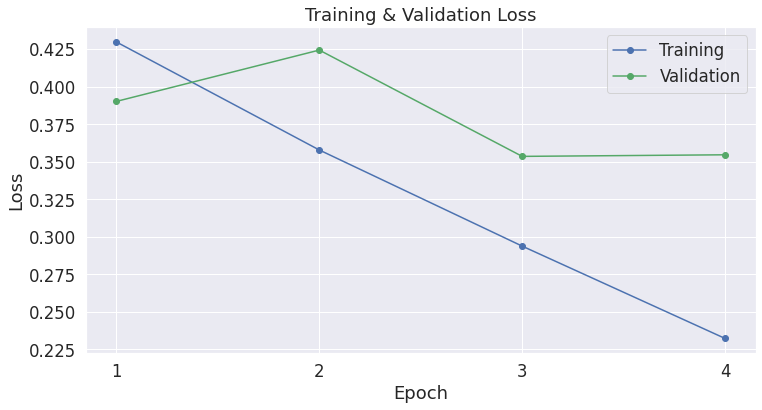

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Evcaluate on test set

In [ ]:

# Create sentence and label lists
sentences = reviews[3000:4000]
labels = score[3000:4000]

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True,
                        max_length = 64,          
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
      
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
  
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []


for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch) 
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,000 test sentences...
    DONE.


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,000 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
print('Calculating Matthews Corr. Coef. for each batch...')

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


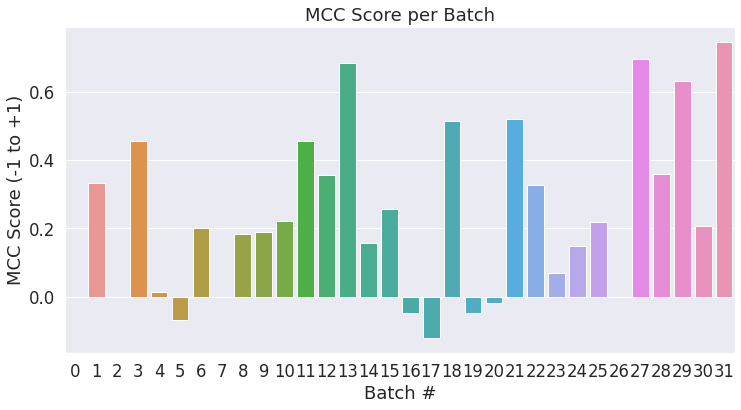

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.273


#Also, compare with Traditional ML Models developed in assignment 1 (train from scratch, ML models in assignment 1 with word2vec and glove embeddings and compare.)

# Generating Embeddings

### Fine Tuned Word2Vec Embedding

In [ ]:
data = []
for i in tqdm(reviews):
  data.append(i.split(' '))
  

100%|██████████| 37126/37126 [00:00<00:00, 179738.73it/s]


In [ ]:
#trains w2v model on data set
w2v_model=Word2Vec(data,min_count=1,size=50, workers=4)

In [ ]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 1 times ",len(w2v_words))
print("sample words ", w2v_words[0:20])

number of words that occured minimum 1 times  47561
sample words  ['big', 'expectation', 'love', 'english', 'tv', 'particular', 'investigative', 'detective', 'stuff', 'guy', 'really', 'boring', 'not', 'appeal', 'highly', 'recommend', 'series', 'must', 'anyone', 'yearning']


In [ ]:
# compute average word2vec for each review.
w2vec_vectors = []; 

for sent in tqdm(data): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    w2vec_vectors.append(sent_vec)

100%|██████████| 37126/37126 [03:10<00:00, 195.18it/s]


In [ ]:
W2vec_train , W2vec_test , score_train, score_test = train_test_split(w2vec_vectors, score,test_size=0.2)

### Fine Tuned Glove Embedding

In [ ]:
# Reading glove embedding file and creating embedding dictionary
# Using 50 dimension embedding vector
initial_embeddings = dict()
f = open('./glove.6B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    initial_embeddings[word] = coefs
f.close()

In [ ]:
#Finding words not in vocabolary
oov = []
for i in data:
  for j in i :
    if ((j not in initial_embeddings.keys()) and (j not in oov)):
      oov.append(j)
corp_vocab = list(set(oov))

cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
X = cv.fit_transform(reviews)
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

In [ ]:
mittens_model = Mittens(n=50, max_iter=500)
new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=corp_vocab,
    initial_embedding_dict= initial_embeddings)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Iteration 500: loss: 0.08615723252296448

In [ ]:
embeddings_index = initial_embeddings
for i in tqdm(range(len(oov))):
  embeddings_index[oov[i]] = new_embeddings[i]

100%|██████████| 9942/9942 [00:00<00:00, 706811.71it/s]


In [ ]:
# compute average Glove for each review.
glove_vectors = []; 
for sent in tqdm(data): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in embeddings_index.keys():
            vec = embeddings_index[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    glove_vectors.append(sent_vec)

100%|██████████| 37126/37126 [00:03<00:00, 10104.92it/s]


In [ ]:
glove_train , glove_test , score_train, score_test = train_test_split(glove_vectors, score,test_size=0.2)

# Naive Bayes with Word2Vec and Glove Embedding

### Word2Vec

In [ ]:
#training  the model

NB_w2vec = BernoulliNB()

NB_word2vec = NB_w2vec.fit(W2vec_train,score_train)
print(NB_word2vec)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


In [ ]:
#Prediction
NB_word2vec_predict=NB_word2vec.predict(W2vec_test)

In [ ]:
# Accuracy

NB_word2vec_acc = accuracy_score(score_test,NB_word2vec_predict)
print("Accuracy Using Naive Base Classifier and Word2vec :",round(NB_word2vec_acc *100,2),'%')

Accuracy Using Naive Base Classifier and Word2vec : 76.8 %


In [ ]:
#F1 Score
NB_word2vec_f1_score = f1_score(score_test,NB_word2vec_predict)
print("F1 Score Using Naive Base classifier and Word2vec :",round(NB_word2vec_f1_score,2))

F1 Score Using Naive Base classifier and Word2vec : 0.85


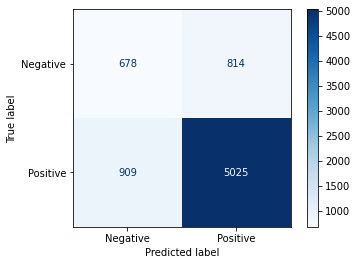

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(NB_word2vec, W2vec_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### Glove Embedding

In [ ]:
#training  the model

NB_glove = BernoulliNB()
NB_glove = NB_glove.fit(glove_train,score_train)
print(NB_glove)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


In [ ]:
#Prediction
NB_glove_predict=NB_glove.predict(glove_test)

In [ ]:
# Accuracy

NB_glove_acc = accuracy_score(score_test,NB_glove_predict)
print("Accuracy Using Naive Base Classifier and Glove Embedding :",round(NB_glove_acc *100,2),'%')

Accuracy Using Naive Base Classifier and Glove Embedding : 78.41 %


In [ ]:
#F1 Score
NB_glove_f1_score = f1_score(score_test,NB_glove_predict)
print("F1 Score Naive Base classifier and Glove Embedding :",round(NB_glove_f1_score,2))

F1 Score Naive Base classifier and Glove Embedding : 0.87


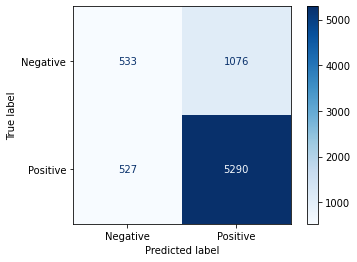

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(NB_glove, glove_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

# Decision Tree with Word2Vec and Glove Embedding

### Word2Vec

In [ ]:
#training  the model
Dtree_word2vec = DecisionTreeClassifier(random_state=0)

Dtree_word2vec = Dtree_word2vec.fit(W2vec_train,score_train)
print(Dtree_word2vec)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


In [ ]:
#Prediction
Dtree_word2vec_predict=Dtree_word2vec.predict(W2vec_test)

In [ ]:
# Accuracy

Dtree_word2vec_acc = accuracy_score(score_test,Dtree_word2vec_predict)
print("Accuracy Using Decision Tree Classifier and Word2vec :",round(Dtree_word2vec_acc *100,2),'%')

Accuracy Using Decision Tree Classifier and Word2vec : 64.95 %


In [ ]:
#F1 Score
Dtree_word2vec_f1_score = f1_score(score_test,Dtree_word2vec_predict)
print("F1 Score Using Decision Tree classifier and Word2vec :",round(Dtree_word2vec_f1_score,2))

F1 Score Using Decision Tree classifier and Word2vec : 0.77


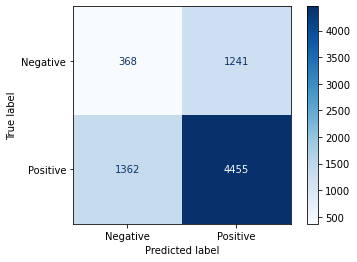

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(Dtree_word2vec, W2vec_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### Glove Embedding

In [ ]:
#training  the model
Dtree_glove = DecisionTreeClassifier(random_state=0)

Dtree_glove = Dtree_glove.fit(glove_train,score_train)
print(Dtree_glove)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


In [ ]:
#Prediction
Dtree_glove_predict=Dtree_glove.predict(glove_test)

In [ ]:
# Accuracy

Dtree_glove_acc = accuracy_score(score_test,Dtree_glove_predict)
print("Accuracy Using Decision Tree Classifier and Glove Embedding :",round(Dtree_glove_acc *100,2),'%')

Accuracy Using Decision Tree Classifier and Glove Embedding : 72.25 %


In [ ]:
#F1 Score
Dtree_glove_f1_score = f1_score(score_test,Dtree_glove_predict)
print("F1 Score Using Decision Tree classifier and Glove Embedding :",round(Dtree_glove_f1_score,2))

F1 Score Using Decision Tree classifier and Glove Embedding : 0.82


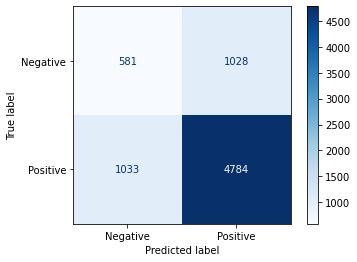

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(Dtree_glove, glove_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

# Logistic Regression with Word2Vec and Glove Embedding

### Word2Vec

In [ ]:
#training  the model

lr_w2vec = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

lr_w2vec.fit(W2vec_train,score_train)
print(lr_w2vec)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
#Prediction
lr_w2vec_predict=lr_w2vec.predict(W2vec_test)

In [ ]:
# Accuracy

lr_w2vec_acc = accuracy_score(score_test,lr_w2vec_predict)
print("Accuracy Using Linear Regression Classifier and Word2vec :",round(lr_w2vec_acc *100,2),'%')

Accuracy Using Linear Regression Classifier and Word2vec : 83.63 %


In [ ]:
#F1 Score
lr_word2vec_f1_score = f1_score(score_test,lr_w2vec_predict)
print("F1 Score Using Linear Regression Classifier and Word2vec  :",round(lr_word2vec_f1_score,2))

F1 Score Using Linear Regression Classifier and Word2vec  : 0.9


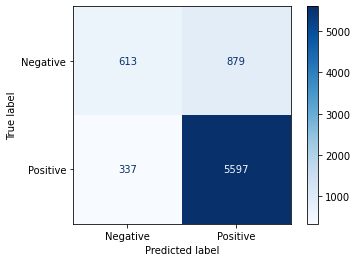

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(lr_w2vec, W2vec_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### Glove Embedding

In [ ]:
#training  the model

lr_glove = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

lr_glove.fit(glove_train,score_train)
print(lr_glove)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
#Prediction
lr_glove_predict=lr_glove.predict(glove_test)

In [ ]:
# Accuracy

lr_glove_acc = accuracy_score(score_test,lr_glove_predict)
print("Accuracy Using Linear Regression Classifier and Glove Embedding :",round(lr_glove_acc *100,2),'%')

Accuracy Using Linear Regression Classifier and Glove Embedding : 80.61 %


In [ ]:
#F1 Score
lr_glove_f1_score = f1_score(score_test,lr_glove_predict)
print("F1 Score Using Linear Regression Classifier and Glove Embedding  :",round(lr_glove_f1_score,2))

F1 Score Using Linear Regression Classifier and Glove Embedding  : 0.89


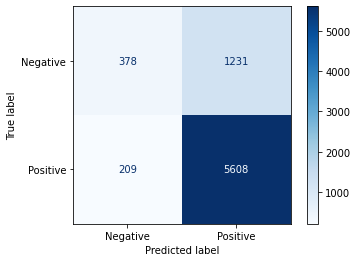

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(lr_glove, glove_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()